# Data Analysis Tools
# Assignment: Running a Chi-Square Test of Independence

Following is the Python program I wrote to fulfill the second assignment of the [Data Analysis Tools online course](https://www.coursera.org/learn/data-analysis-tools/home/welcome).

I decided to use [Jupyter Notebook](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) as it is a pretty way to write code and present results.

As the [previous assignment](Analysis_Variance.ipynb) brought me to conclude my initial research question, I will look at a possible relationship between ethnicity (explanatory variable) and use of cannabis (response variable) from the NESARC database. As both variables are categoricals, the Chi-Square Test of Independence is the method to use.


In [1]:
# Magic command to insert the graph directly in the notebook
%matplotlib inline
# Load a useful Python libraries for handling data
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

## Data management

In [2]:
nesarc = pd.read_csv('nesarc_pds.csv', low_memory=False)

In [26]:
races = {1 : 'White', 
         2 : 'Black', 
         3 : 'American India \n Alaska', 
         4 : 'Asian \n Native Hawaiian \n Pacific',
         5 : 'Hispanic or Latino'}
subnesarc = (nesarc[['S3BQ1A5', 'ETHRACE2A']]
             .assign(S3BQ1A5=lambda x: pd.to_numeric(x['S3BQ1A5'].replace((2, 9), (0, np.nan)), errors='coerce'))
             .assign(ethnicity=lambda x: pd.Categorical(x['ETHRACE2A'].map(races)),
                     use_cannabis=lambda x: pd.Categorical(x['S3BQ1A5']))
             .dropna())
subnesarc.use_cannabis.cat.rename_categories(('No', 'Yes'), inplace=True)

First, the distribution of both the use of cannabis and the ethnicity will be shown.

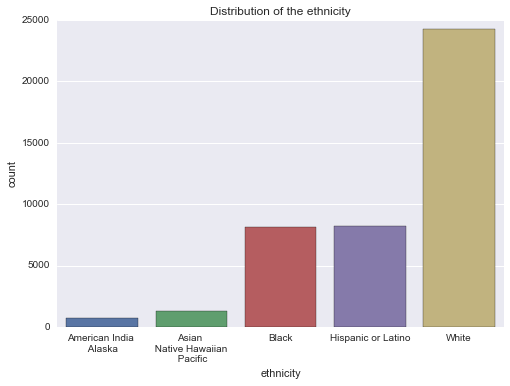

In [29]:
g = sns.countplot(subnesarc['ethnicity'])

_ = plt.title('Distribution of the ethnicity')

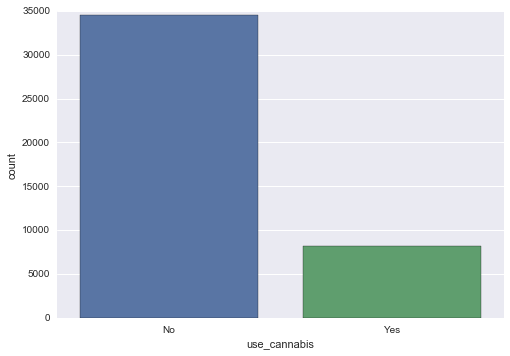

In [28]:
g = sns.countplot(subnesarc['use_cannabis'])
_ = plt.title('Distribution of ever use cannabis')

## Variance analysis

Now that the univariate distribution as be plotted and described, the bivariate graphics will be plotted in order to test our research hypothesis.

From the bivariate graphic below, it seems that there are some differences. For example American Indian versus Asian seems quite different.

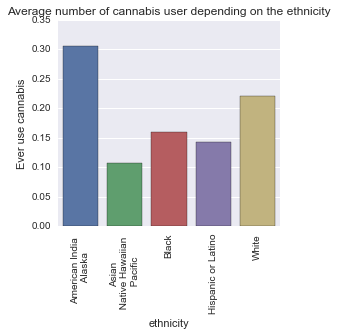

In [30]:
g = sns.factorplot(x='ethnicity', y='S3BQ1A5', data=subnesarc, 
                   kind="bar", ci=None)
g.set_xticklabels(rotation=90)
plt.ylabel('Ever use cannabis')
_ = plt.title('Average number of cannabis user depending on the ethnicity')

In [4]:
ct1 = pd.crosstab(subnesarc.use_cannabis, subnesarc.ethnicity)
display(Markdown("Contingency table of observed counts"))
ct1

Contingency table of observed counts

ethnicity,American India/Alaska,Asian/Native Hawaiian/Pacific,Black,Hispanic or Latino,White
use_cannabis,,,,,
No,482,1186,6847,7077,18961
Yes,212,142,1303,1174,5341


In [11]:
# Note: normalize keyword is available starting from pandas version 0.18.1
ct2 = ct1/ct1.sum(axis=0)
display(Markdown("Contingency table of observed counts normalized over each columns"))
ct2

Contingency table of observed counts normalized over each columns

ethnicity,American India/Alaska,Asian/Native Hawaiian/Pacific,Black,Hispanic or Latino,White
use_cannabis,,,,,
No,0.694524,0.893072,0.840123,0.857714,0.780224
Yes,0.305476,0.106928,0.159877,0.142286,0.219776


The Chi-Square test will be applied on the all data to test the following hypothesis :

- The null hypothesis is *There is no relationship between the use of cannabis and the ethnicity*.
- The alternate hypothesis is *There is a relationship between the use of cannabis and the ethnicity*.

In [6]:
stats.chi2_contingency(ct1)

(427.16448568948812,
 3.7497669790156457e-91,
 4,
 array([[   561.25879462,   1073.99377414,   6591.15155061,   6672.83330603,
          19653.76257461],
        [   132.74120538,    254.00622586,   1558.84844939,   1578.16669397,
           4648.23742539]]))

The p-value of 3.7e-91 confirm that the null hypothesis can be safely rejected.

The next obvious questions is which ethnic groups have a statistically significant difference regarding the use of cannabis. For that, the Chi-Square test will be performed on each pair of group thanks to the following code.

In [13]:
list_races = list(races.keys())
p_values = dict()
for i in range(len(list_races)):
    for j in range(i+1, len(list_races)):
        race1 = races[list_races[i]]
        race2 = races[list_races[j]]
        subethnicity = subnesarc.ETHRACE2A.map(dict(((list_races[i], race1),(list_races[j], race2))))
        comparison = pd.crosstab(subnesarc.use_cannabis, subethnicity)
        display(Markdown("Crosstable to compare {} and {}".format(race1, race2)))
        display(comparison)
        display(comparison/comparison.sum(axis=0))
        
        chi_square, p, _, expected_counts = stats.chi2_contingency(comparison)
        p_values[(race1, race2)] = p

Crosstable to compare White and Black

ETHRACE2A,Black,White
use_cannabis,,
No,6847,18961
Yes,1303,5341


ETHRACE2A,Black,White
use_cannabis,,
No,0.840123,0.780224
Yes,0.159877,0.219776


Crosstable to compare White and American India/Alaska

ETHRACE2A,American India/Alaska,White
use_cannabis,,
No,482,18961
Yes,212,5341


ETHRACE2A,American India/Alaska,White
use_cannabis,,
No,0.694524,0.780224
Yes,0.305476,0.219776


Crosstable to compare White and Asian/Native Hawaiian/Pacific

ETHRACE2A,Asian/Native Hawaiian/Pacific,White
use_cannabis,,
No,1186,18961
Yes,142,5341


ETHRACE2A,Asian/Native Hawaiian/Pacific,White
use_cannabis,,
No,0.893072,0.780224
Yes,0.106928,0.219776


Crosstable to compare White and Hispanic or Latino

ETHRACE2A,Hispanic or Latino,White
use_cannabis,,
No,7077,18961
Yes,1174,5341


ETHRACE2A,Hispanic or Latino,White
use_cannabis,,
No,0.857714,0.780224
Yes,0.142286,0.219776


Crosstable to compare Black and American India/Alaska

ETHRACE2A,American India/Alaska,Black
use_cannabis,,
No,482,6847
Yes,212,1303


ETHRACE2A,American India/Alaska,Black
use_cannabis,,
No,0.694524,0.840123
Yes,0.305476,0.159877


Crosstable to compare Black and Asian/Native Hawaiian/Pacific

ETHRACE2A,Asian/Native Hawaiian/Pacific,Black
use_cannabis,,
No,1186,6847
Yes,142,1303


ETHRACE2A,Asian/Native Hawaiian/Pacific,Black
use_cannabis,,
No,0.893072,0.840123
Yes,0.106928,0.159877


Crosstable to compare Black and Hispanic or Latino

ETHRACE2A,Black,Hispanic or Latino
use_cannabis,,
No,6847,7077
Yes,1303,1174


ETHRACE2A,Black,Hispanic or Latino
use_cannabis,,
No,0.840123,0.857714
Yes,0.159877,0.142286


Crosstable to compare American India/Alaska and Asian/Native Hawaiian/Pacific

ETHRACE2A,American India/Alaska,Asian/Native Hawaiian/Pacific
use_cannabis,,
No,482,1186
Yes,212,142


ETHRACE2A,American India/Alaska,Asian/Native Hawaiian/Pacific
use_cannabis,,
No,0.694524,0.893072
Yes,0.305476,0.106928


Crosstable to compare American India/Alaska and Hispanic or Latino

ETHRACE2A,American India/Alaska,Hispanic or Latino
use_cannabis,,
No,482,7077
Yes,212,1174


ETHRACE2A,American India/Alaska,Hispanic or Latino
use_cannabis,,
No,0.694524,0.857714
Yes,0.305476,0.142286


Crosstable to compare Asian/Native Hawaiian/Pacific and Hispanic or Latino

ETHRACE2A,Asian/Native Hawaiian/Pacific,Hispanic or Latino
use_cannabis,,
No,1186,7077
Yes,142,1174


ETHRACE2A,Asian/Native Hawaiian/Pacific,Hispanic or Latino
use_cannabis,,
No,0.893072,0.857714
Yes,0.106928,0.142286


If we put together all p-values results and test them against our threshold of 0.005, we got the table below.

The threshold is the standard 0.05 threshold divided by the number of pairs in the explanatory variables (here 10).

In [43]:
df = pd.DataFrame(p_values, index=['p-value', ])

(df.stack(level=[0, 1])['p-value']
   .rename('p-value')
   .to_frame()
   .assign(Ha=lambda x: x['p-value'] < 0.05 / len(p_values)))

p-value  \
American India/Alaska         Asian/Native Hawaiian/Pacific  1.364517e-28   
                              Hispanic or Latino             6.938375e-30   
Asian/Native Hawaiian/Pacific Hispanic or Latino             6.016908e-04   
Black                         American India/Alaska          2.474718e-22   
                              Asian/Native Hawaiian/Pacific  7.953423e-07   
                              Hispanic or Latino             1.784392e-03   
White                         American India/Alaska          1.103488e-07   
                              Asian/Native Hawaiian/Pacific  2.230204e-22   
                              Black                          5.133717e-31   
                              Hispanic or Latino             4.477664e-52   

                                                               Ha  
American India/Alaska         Asian/Native Hawaiian/Pacific  True  
                              Hispanic or Latino             True  
Asian/Native Hawaiian/Pacific Hispanic or Latino             True  
Black                         American India/Alaska          True  
                              Asian/Native Hawaiian/Pacific  True  
                              Hispanic or Latino             True  
White                         American India/Alaska          True  
                              Asian/Native Hawaiian/Pacific  True  
                              Black                          True  
                              Hispanic or Latino             True

In this particular case, we can conclude that all ethnic group have a significant relationship with the use of cannabis.

> If you are interested into data sciences, follow me on [Tumblr](http://fcollonval.tumblr.com/).